## Семинар 9: "LSTM"

ФИО:

In [57]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [87]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        """
        inputs: (seq_len, batch_size, input_size)
        hidden: (batch_size, hidden_size) x 2. (no layers)
        """
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            #print('shape:', S.shape)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

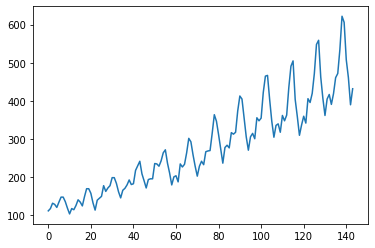

In [414]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [415]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [416]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [417]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [418]:
look_back = 30 # 5
look_forward=1

In [419]:
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

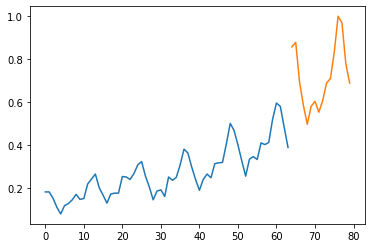

In [420]:
plt.plot(range(0, len(trainY)), trainY)
plt.plot(range(len(trainY), len(trainY) + len(testY)), testY)

In [421]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((64, 30), (16, 30), (64, 1), (16, 1))

In [422]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

### Train-func

In [386]:
def MAPE(y_pred, y_true):
    loss = (y_pred - y_true).abs() / (y_true.abs() + 1e-8)
    return loss.mean() #loss.mean(axis=0)

In [387]:
class LSTM_seq(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()
        self.lstm = LSTM(input_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, 100)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 1)
        
    def forward(self, x):
        hidden = (torch.randn(batch_size, hidden_size),
                    torch.randn(batch_size, hidden_size))
        #hidden = (torch.zeros_like(hidden[0]), torch.zeros_like(hidden[1]))
        #out, hidden = network(X, hidden)
        out, (h_t, c_t) = self.lstm(x, hidden)
        x = self.linear1(h_t)
        x = self.relu1(x)
        x = self.linear2(h_t)
        return x

In [388]:
def train(network, epochs, learning_rate, train_loader, test_loader=None):
    loss = MAPE
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_loader:
                network.zero_grad()
                
                X = X.T
                X = X.reshape(X.shape[0], X.shape[1], 1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
           
            train_loss_epochs.append(np.mean(losses))
            
            if test_loader is not None:
                losses = []
                with torch.no_grad():
                    for X, y in test_loader:

                        X = X.T
                        X = X.reshape(X.shape[0], X.shape[1], 1)
                        prediction = network(X)
                        loss_batch = loss(prediction, y)
                        losses.append(loss_batch.item())

                    test_loss_epochs.append(np.mean(losses))
            
                #clear_output(True)
                if epoch % 10 == 0:
                    print('\rEpoch {0}... (Train/Test) MAPE: {1:.3f}/{2:.3f}'.format(
                                epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            else:
                if epoch % 10 == 0:
                    print('\rEpoch {0}... (Train) MAPE: {1:.3f}'.format(
                                epoch, train_loss_epochs[-1]))
        
        if len(train_loss_epochs) > 0:        
            print('Total loss:', train_loss_epochs[-1])
#             plt.figure(figsize=(12, 5))
#             plt.subplot(1, 2, 1)
#             plt.plot(train_loss_epochs, label='Train')
#             plt.plot(test_loss_epochs, label='Test')
#             plt.xlabel('Epochs', fontsize=16)
#             plt.ylabel('Loss', fontsize=16)
#             plt.legend(loc=0, fontsize=16)
#             plt.grid()
#             plt.subplot(1, 2, 2)
#             plt.plot(train_accuracy_epochs, label='Train accuracy')
#             plt.plot(test_accuracy_epochs, label='Test accuracy')
#             plt.xlabel('Epochs', fontsize=16)
#             plt.ylabel('Loss', fontsize=16)
#             plt.legend(loc=0, fontsize=16)
#             plt.grid()
#             plt.show()
    except KeyboardInterrupt:
        pass

In [389]:
input_size = 1
batch_size = 1
hidden_size = 100
epochs = 50
lr = 0.01

In [390]:
train_dataloader =  DataLoader(train_dataset, batch_size=batch_size)
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size)

In [391]:
network = LSTM_seq(input_size, hidden_size) # 
train(network, epochs, lr, train_dataloader) # test_dataloader

Epoch 0... (Train) MAPE: 0.314
Epoch 10... (Train) MAPE: 0.402
Epoch 20... (Train) MAPE: 0.223
Epoch 30... (Train) MAPE: 0.174
Epoch 40... (Train) MAPE: 0.180
Total loss: 0.1611582737241406


#### Предсказание

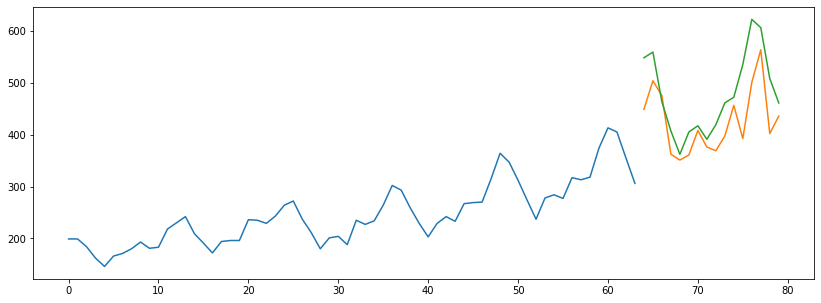

In [426]:
train_values = []
test_values = []
target_values = []

for _, y in train_dataloader:
    train_values += y.flatten().tolist()

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.T
        X = X.reshape(X.shape[0], X.shape[1], 1)
        test_values += network(X).flatten().tolist()
        target_values += y.flatten().tolist()
        

train_values = scaler.inverse_transform( np.array(train_values).reshape(-1, 1) )
test_values = scaler.inverse_transform( np.array(test_values).reshape(-1, 1) )
target_values = scaler.inverse_transform( np.array(target_values).reshape(-1, 1) )

plt.figure(figsize=(14, 5))
plt.plot(range(len(train_values)), train_values)
plt.plot(range(len(train_values), len(train_values) + len(test_values)), test_values)
plt.plot(range(len(train_values), len(train_values) + len(target_values)), target_values)

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/374fc477c4744b009a837153ce135cfb 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 1 мая 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

In [515]:
dataset = pandas.read_csv('train.csv')

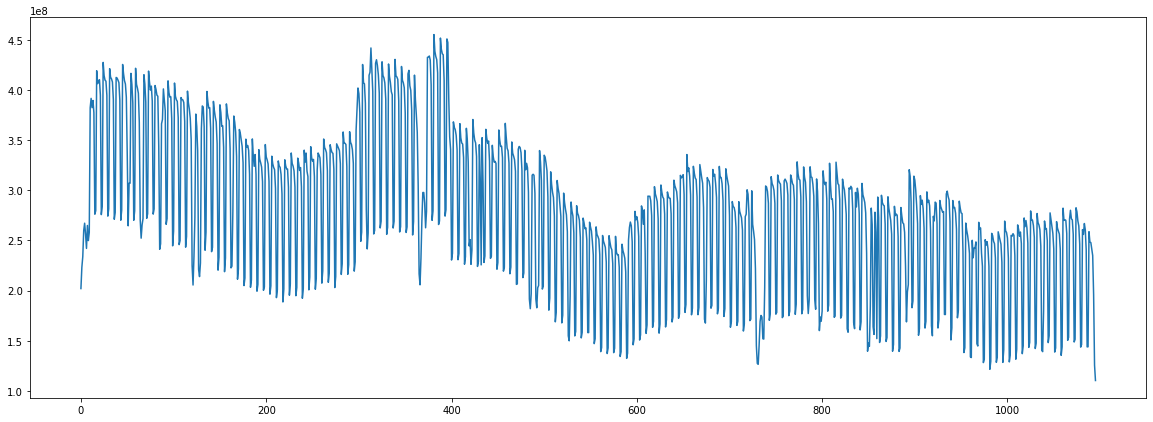

In [516]:
plt.figure(figsize=(20, 7))
plt.plot(range(len(dataset['hits'])), dataset['hits'])
plt.show()

In [517]:
dataset = dataset['hits'].values.reshape(-1, 1) 
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1)) # TODO: standard / (-1;1)
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

734 362


In [518]:
look_back = 365 # по какому-то периоду, 30 дней например
look_forward=1

input_size = 1
batch_size = 1
hidden_size = 100
epochs = 20
lr = 0.001

In [519]:
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = trainX.T.reshape(trainX.shape + (1,))
testX = testX.T.reshape(testX.shape + (1,))

train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size)
test_dataloader =  DataLoader(test_dataset, batch_size=batch_size)

In [520]:
trainX.shape

(367, 365, 1)

In [521]:
class LSTM_comp(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True) # TODO: еще много параметров
        self.linear1 = nn.Linear(hidden_dim, 100) # мб одного слоя достаточно, либо наоборот усложнить
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 1)
        
    def forward(self, x):
        out, (h_t, c_t) = self.lstm(x)
        x = self.linear1(h_t)
        x = self.relu1(x)
        x = self.linear2(h_t)
        return x

In [522]:
def train(network, epochs, learning_rate, train_loader, test_loader=None):
    
    loss = MAPE
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_loader:
                network.zero_grad()

                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
           
            train_loss_epochs.append(np.mean(losses))
            
            if test_loader is not None:
                losses = []
                with torch.no_grad():
                    for X, y in test_loader:

                        prediction = network(X)
                        loss_batch = loss(prediction, y)
                        losses.append(loss_batch.item())

                    test_loss_epochs.append(np.mean(losses))
            
                if epoch % 10 == 0:
                    print('\rEpoch {0}... (Train/Test) MAPE: {1:.3f}/{2:.3f}'.format(
                                epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            else:
                if epoch % 10 == 0:
                    print('\rEpoch {0}... (Train) MAPE: {1:.3f}'.format(
                                epoch, train_loss_epochs[-1]))
        
        if len(train_loss_epochs) > 0:    
            print('Total loss: {} for {} epochs'.format( train_loss_epochs[-1], epochs) )

    except KeyboardInterrupt:
        pass

In [523]:
network = LSTM_comp(input_size, hidden_size)
# loss mse, metric MAPE? 

In [524]:
train(network, epochs, lr, train_dataloader, test_dataloader)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0... (Train/Test) MAPE: 0.486/nan


#### Plot

In [525]:
def plot_prediction(train_dataloader, test_dataloader):
    train_values = []
    test_values = []
    target_values = []

    for _, y in train_dataloader:
        train_values += y.flatten().tolist()

    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.T
            X = X.reshape(X.shape[0], X.shape[1], 1)
            test_values += network(X).flatten().tolist()
            target_values += y.flatten().tolist()


    train_values = scaler.inverse_transform( np.array(train_values).reshape(-1, 1) )
    test_values = scaler.inverse_transform( np.array(test_values).reshape(-1, 1) )
    target_values = scaler.inverse_transform( np.array(target_values).reshape(-1, 1) )

    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_values)), train_values)
    plt.plot(range(len(train_values), len(train_values) + len(test_values)), test_values)
    plt.plot(range(len(train_values), len(train_values) + len(target_values)), target_values)

In [526]:
plot_prediction(train_dataloader, test_dataloader)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.